In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
from models.sub_tcn import Sub_TCN
from models.gru import GRU

# Cosine Bases

In [2]:
cos_basis_no = 30
scale = 7.5
shift = 1
T_no = 500
        
kern_basis = torch.zeros(cos_basis_no, T_no)
for i in range(cos_basis_no):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = scale  * torch.log(x_in + shift + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis

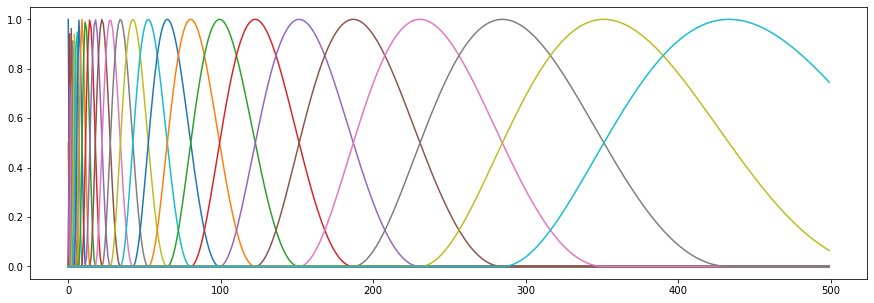

In [3]:
plt.figure(figsize = (15,5))
for i in range(cos_basis_no):
    plt.plot(kern_basis[i].cpu().detach().numpy())

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust8-30"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

C_syn_e = np.load("/media/hdd01/sklee/CA1_clust8-30/data/handsub14_C_syn_e.npy")
C_syn_i = np.load("/media/hdd01/sklee/CA1_clust8-30/data/handsub14_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

C_syn_e = C_syn_e[:,e_idx]
C_syn_i = C_syn_i[:,i_idx]

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 14
#E_no = 2000
#I_no = 200
E_no = e_idx.shape[0]
I_no = i_idx.shape[0]
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 4
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.025**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.025)

# GRU (1 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025/(1**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2162


In [6]:
score_list = []

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    #V_pred, _ = model(batch_E_neural, batch_I_neural)
    V_pred, _, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    s = time.time()
    
    loss = torch.mean((V_pred- batch_V[:,5000:35000] )**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred, test_sub_out, _ = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[5000:35000], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[5000:35000]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-6-9b71b80f8108>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 -0.03874 0.067268
49 0.168302 0.053852
99 0.186927 0.052722
149 0.200924 0.051928
199 0.202344 0.051628
249 0.207242 0.051298
299 0.208478 0.051253
349 0.21259 0.051011
399 0.208492 0.051394
449 0.214111 0.051018
499 0.209433 0.051527
549 0.214685 0.050885
599 0.214993 0.050801
649 0.213809 0.051069
699 0.215383 0.050908
749 0.214913 0.051028
799 0.213388 0.050902
849 0.217835 0.050768
899 0.220283 0.050585
949 0.21852 0.050795
999 0.220904 0.050425
1049 0.218876 0.050636
1099 0.224947 0.050173
1149 0.221542 0.050362
1199 0.216366 0.050945
1249 0.221447 0.050456
1299 0.22263 0.050537
1349 0.223101 0.050314
1399 0.224677 0.05017
1449 0.226522 0.050041
1499 0.232113 0.049707
1549 0.223809 0.050642
1599 0.224293 0.050189
1649 0.228571 0.049978
1699 0.232778 0.049651
1749 0.22881 0.050102
1799 0.228294 0.050128
1849 0.234252 0.04954
1899 0.237898 0.049303
1949 0.234852 0.049927
1999 0.228951 0.049964
2049 0.238348 0.04941
2099 0.226622 0.050187
2149 0.238991 0.049233
2199 0.232001 0.0499

17699 0.412818 0.038135
17749 0.414016 0.037988
17799 0.402741 0.039012
17849 0.413294 0.038055
17899 0.40158 0.038745
17949 0.401549 0.038812
17999 0.408053 0.038311
18049 0.408472 0.038354
18099 0.40681 0.038381
18149 0.406402 0.038444
18199 0.403361 0.038673
18249 0.404922 0.038501
18299 0.413547 0.037979
18349 0.410518 0.038136
18399 0.4058 0.038708
18449 0.406596 0.038403
18499 0.413833 0.037958
18549 0.405297 0.038679
18599 0.401863 0.038701
18649 0.401221 0.039084
18699 0.407416 0.038343
18749 0.394875 0.039182
18799 0.407505 0.038417
18849 0.415261 0.037913
18899 0.411782 0.038174
18949 0.405724 0.038446
18999 0.410105 0.038163
19049 0.391843 0.039357
19099 0.404963 0.038495
19149 0.407751 0.03847
19199 0.408554 0.038608
19249 0.403389 0.038607
19299 0.402982 0.038636
19349 0.413792 0.037928
19399 0.406037 0.038443
19449 0.400334 0.038799
19499 0.414642 0.038127
19549 0.406901 0.03837
19599 0.411518 0.038072


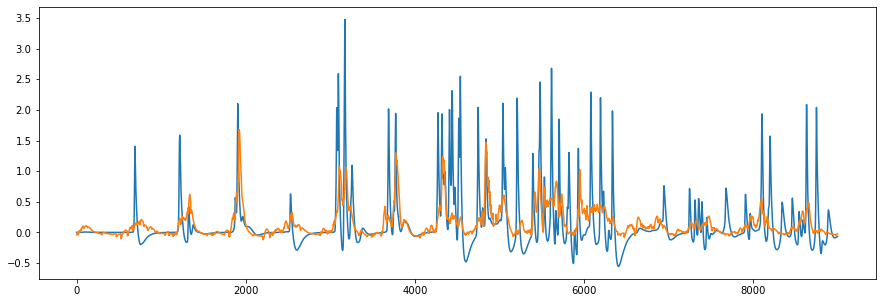

In [7]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:26000])

In [8]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_noNA/random/glm_s10_h2.pt")